In [1]:
import math
import torch
import torchvision
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, Normalize, PILToTensor, RandomRotation,\
      RandomVerticalFlip, RandomHorizontalFlip, RandomErasing,RandomResizedCrop,ConvertImageDtype,CenterCrop
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.style.use("dark_background")
torch.manual_seed(21297)


%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [10]:
class GeLU(nn.Module):

    def __init__(self):
        super(GeLU, self).__init__()
    def forward(self, x):
        return x*F.sigmoid(1.702*x)
    

class LayerNorm(nn.Module):

    def __init__(self):
        super(LayerNorm, self).__init__()
        self.mu = nn.Parameter(torch.tensor([0.]))
        self.sigma = nn.Parameter(torch.tensor([1.]))
    
    def forward(self, x:torch.Tensor, eps=1e-5):
        b, n, d = x.shape
        x_m = x.mean(-1, keepdim=True)
        x_var = x.var(-1, keepdim=True)
        x = (x - x_m)/(x_var + eps).sqrt()
        return self.mu + self.sigma*x


class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, dim):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros((seq_len, dim))
        pos = torch.arange(0, seq_len, step=1).unsqueeze(1)
        wavelen = torch.exp(-math.log(1e4)*(2*torch.arange(0, dim//2, 1)*dim**-1)).float()
        pe[:, 0::2] = torch.sin(pos*wavelen)
        pe[:, 1::2] = torch.cos(pos*wavelen)

        self.register_buffer("pe", pe, persistent=False)
        self.pe = self.pe.unsqueeze(0)
    def forward(self, x):
        assert x.shape[2] == self.pe.shape[2]
        return x + self.pe[:, :x.shape[1], :]

     
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, d):
        assert d%num_heads==0
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d = d
        self.head_dim = d//num_heads

        self.qkv = nn.Linear(d, 3*d)
        self.proj = nn.Linear(d, d)
        self.scale = self.head_dim**-0.5

    def forward(self, x):
        b, n, d = x.shape
        q, k ,v = self.qkv(x).reshape(b, self.num_heads, n, -1).chunk(3, -1)
        attn_score = F.softmax(q@k.transpose(2, 3)*self.scale, dim=-1)
        out = attn_score@v
        out = out.permute((0, 2, 1, 3))
        out = out.reshape((b, n, -1))

        return attn_score, out



class TransformerBlock(nn.Module):

    def __init__(self, num_heads, d, prenorm=True):
        super(TransformerBlock, self).__init__()

        self.prenorm = prenorm
        self.mha = MultiHeadAttention(num_heads=num_heads, d=d)
        self.layernorm1 = LayerNorm()
        self.layernorm2 = LayerNorm()
        self.linear = nn.Sequential(
            nn.Linear(d, 2*d),
            GeLU(),
            nn.Dropout(),
            nn.Linear(2*d, d),
            nn.Dropout()
        )

    def forward(self, input_feat):
        x = input_feat
        if self.prenorm:
            x_norm = self.layernorm1(x) 
            score, x_att = self.mha(x_norm)
            x = self.layernorm2(x + x_att)
            return score, x + self.linear(x)
        else:
            score, x_att = self.mha(x)
            x_norm = self.layernorm1(x + x_att)
            x = self.linear(x_norm)
            return score, self.layernorm2(x_norm + x)




class VisionTransformer(nn.Module):

    def __init__(self, L, H, A, patch_size=16, seq=4, num_classes=10):
        super(VisionTransformer, self).__init__()
        self.L = L
        self.H = H
        self.A = A

        self.input_layer = nn.Linear(3*patch_size**2, self.H)
        self.transformer = nn.ModuleDict({f"t_block_{i}": \
                                          TransformerBlock(num_heads=self.A, d = self.H)\
                                            for i in range(self.L)})
        self.classifier = nn.Linear(self.H, num_classes)
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.H))
        #self.pe = nn.Parameter(torch.randn(1, seq + 1, self.H))
        self.pe = PositionalEncoding(seq_len=seq+1, dim=H)
        

    def forward(self, x:torch.Tensor, return_scores=False):
        b, n, d = x.shape
        attn_dict = {}
        x = self.input_layer(x)
        cls_token = self.cls_token.repeat((b, 1, 1))
        x = torch.cat([cls_token, x], dim=1)
        x = self.pe(x)

        for name, module in self.transformer.items():
            score, x = module(x)
            attn_dict[name] = score
        x = x.transpose(0, 1)
        return attn_dict, self.classifier(x[0])
        

In [11]:
class Patchify(object):
    def __init__(self, patch_size):
        self.patch_size = patch_size
    
    def __call__(self, batch):
        c, h, w = batch.shape
        unfolded = F.unfold(batch, kernel_size=self.patch_size, stride=self.patch_size)
        return unfolded.transpose(0, 1)

In [12]:
def get_dataloaders(
        dataset: str,
        transforms="default",
        train_batch_size=32,
        val_batch_size=32,
        num_workers=4
        ):
    

    dataset_config ={
        "cifar10": torchvision.datasets.CIFAR10,
        "cifar100": torchvision.datasets.CIFAR100
    }
    dataset = dataset_config[dataset]

    if transforms=="default":
        transforms = Compose([
            Resize(32),
            PILToTensor(),
            Normalize()
        ])
    train_data = DataLoader(
        dataset(root="data", train=True, download=True, transform=transforms["train"]),
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=num_workers
        )
    val_data = DataLoader(
        dataset(root="data", train=False, download=True, transform=transforms["val"]),
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers//2,
        )
    
    return train_data, val_data


def show_sample(batch: torch.Tensor, nrows=2,attn=None):
    n, e = batch.shape
    patch = int((e/3)**0.5)
    batch = batch.reshape((n, 3, patch, patch))
    if attn is not None:
        grid = make_grid(batch, nrow=nrows, padding=0)
        c, h, w = grid.shape
        scale = torch.tensor([0.5]).repeat(c,h,w)
        grid = grid*scale + scale 
        plt.imshow(grid.permute(1, 2, 0))
        plt.imshow(attn,alpha=0.6, cmap="inferno")
        plt.show()

In [13]:
transforms = {
    "train":Compose([
    PILToTensor(),
    Resize(32, antialias=True),
    ConvertImageDtype(torch.float),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    RandomVerticalFlip(p=0.3),
    RandomHorizontalFlip(p=0.3),
    RandomResizedCrop(32, antialias=True),
    RandomErasing(p=0.2),
    Patchify(patch_size=(4, 4))
]),
    "val": Compose([
    Resize(32, antialias=True),
    PILToTensor(),
    ConvertImageDtype(torch.float),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Patchify(patch_size=(4, 4))])

}

train_loader, val_loader = get_dataloaders(dataset="cifar10", transforms=transforms, train_batch_size=32, val_batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
x, y =next(iter(val_loader))

In [15]:
show_sample(x[29], nrows=8)

In [16]:
class Learner:
    def __init__(
            self,
            model,
            train_data,
            val_data,
            criterion,
            optimizer,
            lr,
            epochs=10,
            scheduler=None,
            device:str="cuda:0",
    ):
        self.device = torch.device(device)
        self.model = model.to(self.device)
        self.train = train_data
        self.val = val_data
        self.optimizer = optimizer(self.model.parameters(), lr=lr)
        self.criterion = criterion
        self.epochs = epochs
        self.sched = scheduler(self.optimizer, T_max = len(self.train)*self.epochs, eta_min=1e-7) if scheduler else None
        self.history = {"train": {"loss":[], "acc": []}, "val": {"loss": [], "acc": []}}

    def train_step(self, batch):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        attn, out = self.model(x)
        loss = self.criterion(out, y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        if self.sched:
            self.sched.step()
        return loss.mean().item(), (out.argmax(-1)==y).sum().item()
        

    def val_step(self, batch):
        with torch.no_grad():
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)
            attn, out = self.model(x)
            loss = self.criterion(out, y)
            return loss.mean().item(), (out.argmax(-1)==y).sum().item()
    
    def learn(self):
        with tqdm(range(1, self.epochs+1), unit="epoch") as epo:
            for e in epo:
                running_loss = 0.
                running_acc = 0.

                for mini_batch in self.train:
                    loss, acc = self.train_step(mini_batch)
                    running_loss+=loss
                    running_acc+=acc

                self.history["train"]["loss"].append(running_loss/len(self.train))
                self.history["train"]["acc"].append(running_acc/len(self.train.dataset))
                self.evaluate()
                epo.set_postfix({
                                "train_loss": self.history["train"]["loss"][-1],
                                "train_acc": f"{self.history['train']['acc'][-1]*100:.2f}%",
                                "val loss": self.history["val"]["loss"][-1],
                                "val acc": f"{self.history['val']['acc'][-1]*100:.2f}%"
                })


    def evaluate(self):
        running_loss = 0.
        running_acc = 0.
        
        for mini_batch in self.val:
            loss, acc = self.val_step(mini_batch)
            running_loss+=loss
            running_acc+=acc
                
        self.history["val"]["loss"].append(running_loss/len(self.val))
        self.history["val"]["acc"].append(running_acc/len(self.val.dataset))
            

In [17]:
model = VisionTransformer(L=4, H=512, A=8, patch_size=4, seq=64)
agent =Learner(
    model=model,
    train_data=train_loader,
    val_data=val_loader,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    lr=2e-4,
    epochs=50,
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
)
agent.learn()

  0%|          | 0/50 [00:00<?, ?epoch/s]

In [10]:
# model = torch.load("agent-b32-lr2e03-nosched-e500.pth")

# agent =Learner(
#     model=model,
#     train_data=train_loader,
#     val_data=val_loader,
#     optimizer=torch.optim.Adam,
#     criterion=nn.CrossEntropyLoss(),
#     lr=2e-4,
#     epochs=500,
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
# )

# agent.learn()

  0%|          | 0/500 [00:00<?, ?epoch/s]

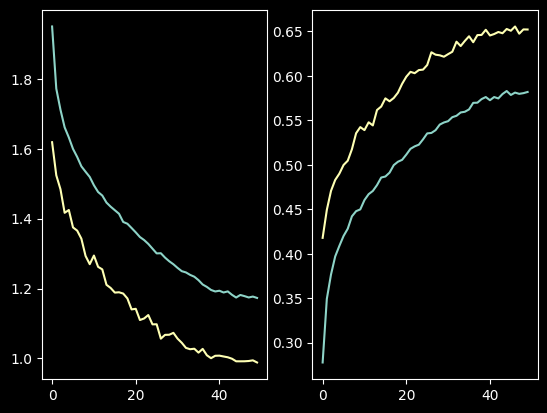

In [18]:
f = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(agent.history["train"]["loss"])
plt.plot(agent.history["val"]["loss"])

plt.subplot(1, 2, 2)
plt.plot(agent.history["train"]["acc"])
plt.plot(agent.history["val"]["acc"])
plt.show()

In [19]:
i = F.fold(x[29].transpose(0,1), (32, 32),kernel_size=(4,4), stride=(4,4))
i = torch.einsum("ijk->jki",i)

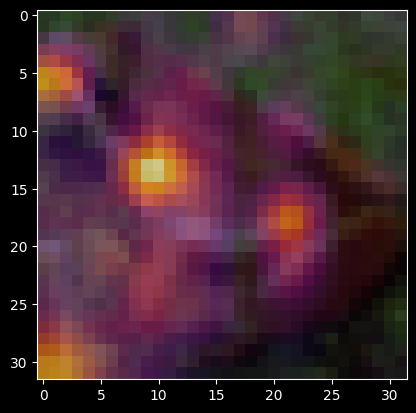

In [113]:
idx=29
o = model(x[idx].unsqueeze(0).cuda())
cls_map = o[0]["t_block_3"][0, :, 0, 1:].reshape(8, -1)
cls_map = cls_map.reshape(8, 32//4, 32//4)
cls_map = Resize(32)(cls_map)
show_sample(x[idx].cpu(), attn=cls_map.detach().cpu().sum(0), nrows=8)

In [45]:
p = model.pe.pe.squeeze(0)[1:,...].detach().cpu()
p = p@p.T

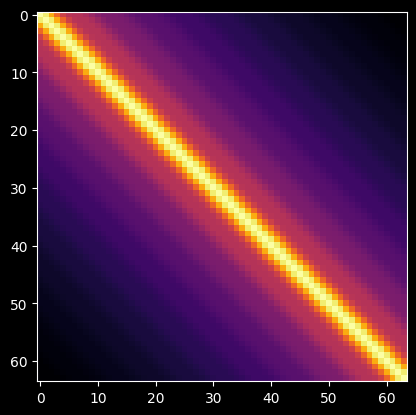

In [46]:
plt.imshow(p, cmap="inferno")